In [91]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import seaborn as sns

import string
import re
import py_vncorenlp
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import os
import matplotlib.pyplot as plt
import pickle

import logging
import pyLDAvis.gensim
from numpy import array
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
# import ldamallet
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases
from gensim.models.coherencemodel import CoherenceModel
import os

import math


# 1. Import users' comments data that are crawled previously

In [3]:
test_data = pd.read_csv(r'D:\ITfiles\PythonFiles\News-Recommendation-System\Use-vnexpress-data\data.csv')
#test_data=test_data[['comment_id','article_id','content','full_name','userid','title','url']]
test_data =  test_data.iloc[0:100000,:]

In [4]:
# Combine comments with one user
def combineComments(userid,data):
    comments = test_data.loc[test_data['userid']==userid,'content'].to_list()

    if len(comments)>= 5:
       comment_id	= test_data.loc[test_data['userid']==userid,'comment_id'].to_list()
       article_id	= test_data.loc[test_data['userid']==userid,'article_id'].to_list()
       title	= test_data.loc[test_data['userid']==userid,'title'].to_list()
       url = test_data.loc[test_data['userid']==userid,'url'].to_list()
       append	= [userid,comments,comment_id,article_id,title,url]
       data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']), 
              ignore_index=True)
       return(data)
       
    else:
       return(data)

# 2. Analyze Users' Comments

In [5]:
# Cobining comments with one user and only get 6 features from dataset
userid_list = list(test_data['userid'].unique())
data = pd.DataFrame(columns = ["userid","comments","comments_id","article_id","title",'url'])

for i in userid_list:
    try:
        temp = int(i)
        data = combineComments(i,data)
    except:
        print('x')
        continue

C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.

x


C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.

In [6]:
data.head()

,userid,comments,comments_id,article_id,title,url
0,1002611535,"[Ủa, iOS có tính năng khóa App từ lâu rồi mà. ...","[47968853, 47800135, 47703811, 47645657, 47584...","[4529373, 4527283, 4524455, 4522989, 4521000, ...",[Ý tưởng iOS 17 có khóa ứng dụng - VnExpress S...,[https://vnexpress.net/y-tuong-ios-17-co-khoa-...
1,1002611542,[Lâu nay phạt nguội xe máy vẫn là vấn đề nan g...,"[48165879, 48157811, 48157769, 48132386, 48088...","[4537874, 4537422, 4537406, 4535990, 4535329, ...","[Môtô CSGT tông liên hoàn, ba người bị thương ...",[https://vnexpress.net/moto-csgt-tong-lien-hoa...
2,1002611620,[Messi 0d nhưng lại được định giá gần gấp 3 lầ...,"[48163846, 48163447, 48162509, 48159323, 48156...","[4537829, 4537929, 4537576, 4537847, 4537527, ...",[10 đội tuyển đắt giá nhất tại World Cup 2022 ...,[https://vnexpress.net/10-doi-tuyen-dat-gia-nh...
3,1002611661,[Hy vọng 30 năm nữa hoàn thành để tôi có thể đ...,"[47983237, 38548809, 37953883, 37023659, 36523...","[4528558, 4226031, 4201350, 4167048, 4144167, ...",[Nghiên cứu đường sắt tốc độ cao 250 km/h - Vn...,[https://vnexpress.net/nghien-cuu-duong-sat-to...
4,1002611711,[Năm rồi vì 20 giây<br/>Mà cả đội bóng vạ lây ...,"[46444497, 46311714, 43222717, 42102514, 42097...","[4492456, 4488831, 4396253, 4356490, 4356752, ...",[Man Utd có thể nhờ Ferguson thuyết phục Ronal...,[https://vnexpress.net/man-utd-co-the-nho-ferg...


Tiền xử lý:
  - Làm sạch loại bỏ ký tự đặc biệt và dấu câu
  - chuẩn hóa về chữ thường
  - Loại bỏ stop words
  - Thay thế các url trong dữ liệu bởi nhãn link_spam
  - Xử lý các trường hợp người dùng láy láy âm tiết(Ví dụ: Ngooon quááááá điiiiiiii !!!!!)
  - Chuẩn hóa các từ viết tắt cơ bản(Ví dụ: k, ko, k0 --> không, bt --> bình thường,...) (teencode)
  - Loại bỏ số và các từ chỉ có 1 ký tự

In [7]:
# init segmenter, stopwords list and exclude punctuation
segmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='D:/ITfiles/PythonFiles/News-Recommendation-System')
stop = set(line.strip() for line in open('stop_words.txt', encoding='utf-8'))
exclude = set(string.punctuation) 

In [8]:
# function to preprocessing comments 
def processComments(comments):
    #cleaning of comments
    cleanedcomments = []
    for comment in comments:
        if (type(comment)!=str):
            continue

        clean = re.compile('<.*?>')
        comment = re.sub(clean, ' ', comment) # remove html tags

        cm = re.sub('http\S+', '', comment) #remove links
        
        cm = "".join([char for char in cm if char not in string.punctuation]) #remove punctuations
        
        cm = cm.lower() #converting to lowercase letters
        
        cm = ' '.join([word for word in cm.split() if word not in (stop)]) #removing stop words
        
        cm = ' '.join([word for word in cm.split() if len(word)>2])
        
        cleanedcomments.append(cm)

    cleanedcomments = ' '.join(cleanedcomments) #joining all comments
    Processedcomments = segmenter.word_segment(cleanedcomments)[0] # tokenize all comments
    Processedcomments

    return Processedcomments
    
# process all tweet from all user (ptweets). then, appending into dataframe (only one dataframe)

<>:12: DeprecationWarning: invalid escape sequence \S
<>:12: DeprecationWarning: invalid escape sequence \S
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\4200551624.py:12: DeprecationWarning: invalid escape sequence \S
  cm = re.sub('http\S+', '', comment) #remove links


In [9]:
data["pcomment"] = data['comments'].apply(lambda x : processComments(x))

In [10]:
data

,userid,comments,comments_id,article_id,title,url,pcomment
0,1002611535,"[Ủa, iOS có tính năng khóa App từ lâu rồi mà. ...","[47968853, 47800135, 47703811, 47645657, 47584...","[4529373, 4527283, 4524455, 4522989, 4521000, ...",[Ý tưởng iOS 17 có khóa ứng dụng - VnExpress S...,[https://vnexpress.net/y-tuong-ios-17-co-khoa-...,ios năng khoá app mục screen time nguyên_nhân ...
1,1002611542,[Lâu nay phạt nguội xe máy vẫn là vấn đề nan g...,"[48165879, 48157811, 48157769, 48132386, 48088...","[4537874, 4537422, 4537406, 4535990, 4535329, ...","[Môtô CSGT tông liên hoàn, ba người bị thương ...",[https://vnexpress.net/moto-csgt-tong-lien-hoa...,phạt nguội máy vấn nan_giải phương xác_định ch...
2,1002611620,[Messi 0d nhưng lại được định giá gần gấp 3 lầ...,"[48163846, 48163447, 48162509, 48159323, 48156...","[4537829, 4537929, 4537576, 4537847, 4537527, ...",[10 đội tuyển đắt giá nhất tại World Cup 2022 ...,[https://vnexpress.net/10-doi-tuyen-dat-gia-nh...,messi định_giá gấp thiên phản_bội ghi haha lik...
3,1002611661,[Hy vọng 30 năm nữa hoàn thành để tôi có thể đ...,"[47983237, 38548809, 37953883, 37023659, 36523...","[4528558, 4226031, 4201350, 4167048, 4144167, ...",[Nghiên cứu đường sắt tốc độ cao 250 km/h - Vn...,[https://vnexpress.net/nghien-cuu-duong-sat-to...,vọng hoàn_thành_thể chuyến chết tội mấy tung t...
4,1002611711,[Năm rồi vì 20 giây<br/>Mà cả đội bóng vạ lây ...,"[46444497, 46311714, 43222717, 42102514, 42097...","[4492456, 4488831, 4396253, 4356490, 4356752, ...",[Man Utd có thể nhờ Ferguson thuyết phục Ronal...,[https://vnexpress.net/man-utd-co-the-nho-ferg...,giây đội bóng lây chàng đôn_đáo chạy_làng rải ...
...,...,...,...,...,...,...,...
1167,1003195439,"[Tôi xài 8 plus thấy rất ổn, Lối ta đi giữa ha...","[46044055, 29691965, 10433034, 27570363, 29377...","[4481312, 3897180, 3145171, 3815894, 3889648, ...",[Đợt giảm giá iPhone lớn nhất trong năm của Ap...,"[https://vnexpress.net/bai-viet-4481312.html, ...",xài plus lối hai sườn núi ðôi làng gọi núi ðôi...
1168,1003195859,[Wesley tài năng nhưng phong thái có hướng ngạ...,"[41386472, 41339327, 39775020, 39416598, 36783...","[4338061, 4337045, 4274638, 4261133, 4157861, ...",[Wesley So: 'Quang Liêm chơi gần được như Vua ...,[https://vnexpress.net/wesley-so-quang-liem-ch...,wesley tài_năng phong_thái hướng ngạo_mạn học ...
1169,1003196529,"[chắc chắn không đủ rồi bạn ạ, có cái nào sạc ...","[47914824, 47641137, 46962534, 44949146, 40693...","[4530246, 4522291, 4505119, 4450832, 4303233, ...",[Du học nghề ở Mỹ cần bao nhiêu tiền? - VnExpr...,[https://vnexpress.net/du-hoc-nghe-o-my-can-ba...,chắn sạc 30s kho khí nắm thiệt hoá liệu hành t...
1170,1003196765,[Phải nói là CR7 đã nói ra mặt tối tại MU khôn...,"[48098544, 47954741, 40042300, 38589111, 34952...","[4536003, 4531933, 4282989, 4227893, 4084948, ...",[Man Utd thông báo về cuộc phỏng vấn của Ronal...,[https://vnexpress.net/man-utd-thong-bao-ve-cu...,cr7 mặt tối cầu_thủ dám siralex dần hình_bóng ...


# 3. Cluster users according to their interests

In [11]:
# create tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1,
                                 use_idf=True)

# fit tfidf from pcomments
tfidf_matrix = tfidf_vectorizer.fit_transform(data.pcomment)

In [12]:
tfidf_matrix.toarray()

array([[0.0124421 , 0.        , 0.        , ..., 0.02432511, 0.        ,
        0.01952885],
       [0.03196714, 0.        , 0.        , ..., 0.01041631, 0.        ,
        0.        ],
       [0.        , 0.03727008, 0.        , ..., 0.02200202, 0.        ,
        0.        ],
       ...,
       [0.03407192, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01414868, 0.        ,
        0.        ]])

In [13]:
tfidf_matrix.shape
# (users x words)

(1172, 1098)

In [14]:
# show user matrix word from tfidf
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names(), index = data.userid)

C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,100,1000,200,2022,500,android,anti,app,apple,ban,...,đức,đứng,đứt,đừng,ước,ảnh,ảnh_hưởng,ủng,ứng,ứng_dụng
userid,,,,,,,,,,,,,,,,,,,,,
1002611535,0.012442,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.103720,0.000000,0.015541,...,0.000000,0.011435,0.000000,0.016590,0.000000,0.013879,0.025582,0.024325,0.000000,0.019529
1002611542,0.031967,0.000000,0.0,0.0,0.000000,0.279700,0.016300,0.000000,0.469082,0.013309,...,0.000000,0.000000,0.017766,0.021313,0.000000,0.011886,0.010955,0.010416,0.000000,0.000000
1002611620,0.000000,0.037270,0.0,0.0,0.000000,0.078773,0.000000,0.037526,0.000000,0.000000,...,0.000000,0.103429,0.000000,0.030012,0.000000,0.150642,0.000000,0.022002,0.000000,0.000000
1002611661,0.085575,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.071337,0.000000,0.057790,0.000000,0.000000,0.000000,0.000000,0.000000
1002611711,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.015855,0.000000,0.000000,0.000000,...,0.077362,0.009526,0.000000,0.013821,0.013999,0.000000,0.031967,0.010132,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003195439,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.078851,0.000000,0.057200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1003195859,0.035769,0.029614,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.016437,0.000000,0.035771,0.000000,0.000000,0.000000,0.000000,0.029415,0.000000
1003196529,0.034072,0.000000,0.0,0.0,0.058160,0.000000,0.208477,0.000000,0.051721,0.000000,...,0.000000,0.000000,0.000000,0.045432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
# save model tf-idf parameters
location = 'model/'
if not os.path.exists(location):
    os.makedirs(location)

pickle.dump(tfidf_vectorizer, open("%smodel_tfidf.pickle.dat"%location, "wb")) # Save object

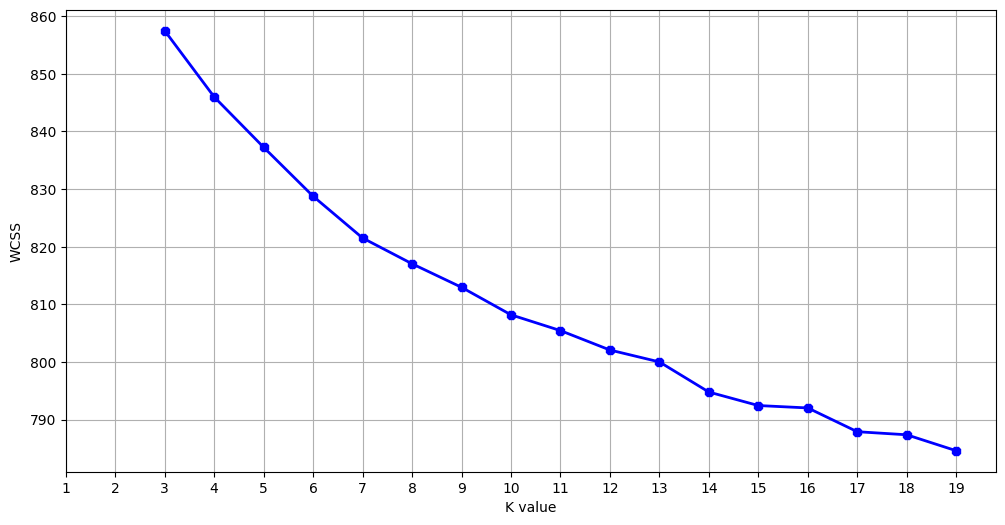

In [16]:
# find number cluster use tf-idf
wcss = []
for k in range(3, 20):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(3,20),wcss, linewidth=2, color="blue",marker="8")
plt.xlabel("K value")
plt.xticks(np.arange(1,20,1))
plt.ylabel("WCSS")
plt.show()

In [17]:
# cluster with 8 clusters that are found above
num_clusters = 8

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [18]:
km.cluster_centers_.argsort()[:, ::-1]

array([[ 472,   34,  863, ...,  971,   21,  801],
       [ 339,  480,  479, ...,  416,  164,    3],
       [ 480,  247,  487, ...,  839,  858,  352],
       ...,
       [ 728,  237,  601, ...,  445,  149,  935],
       [ 517,  247,  480, ...,   65,  172,  547],
       [  34,  863, 1080, ...,  317,  549,  707]], dtype=int64)

In [19]:
# show top word per cluster, which show interest of each cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 messi
 bóng
 trận
 fan
 cr7
 barca
 đội
 cầu_thủ
 real
 ghi_bàn
Cluster 1:
 học
 mua
 mong
 chúc
 đọc
 tui
 chúc_mừng
 tiền
 dân
 thể
Cluster 2:
 mua
 giá
 máy
 tiền
 chạy
 iphone
 đường
 hãng
 mấy
 nhật
Cluster 3:
 tiền
 mua
 học
 giá
 sống
 chồng
 thể
 đường
 mấy
 đầu
Cluster 4:
 việt_nam
 bóng
 trận
 đẹp
 chúc_mừng
 tiền
 chúc
 hai
 mấy
 lắm
Cluster 5:
 thi
 gia
 pha
 chi
 tha
 chu
 nghi
 nha
 nga
 tra
Cluster 6:
 nga
 giá
 mua
 tiền
 châu
 dầu
 hàng
 thể
 mấy
 điện
Cluster 7:
 bóng
 trận
 đội
 cầu_thủ
 thắng
 hlv
 việt_nam
 thua
 giải
 tiền


C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
# Save model parameters
pickle.dump(km, open("%smodel_kmeans.pickle.dat"%location, "wb"))

In [21]:
# reduce the dimension tf-idf
dist = 1 - cosine_similarity(tfidf_matrix)
dist

MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

In [22]:
# set name to cluster
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4', 
                 5: 'Cluster 5',
                 6: 'Cluster 6',
                 7: 'Cluster 7',
                 }

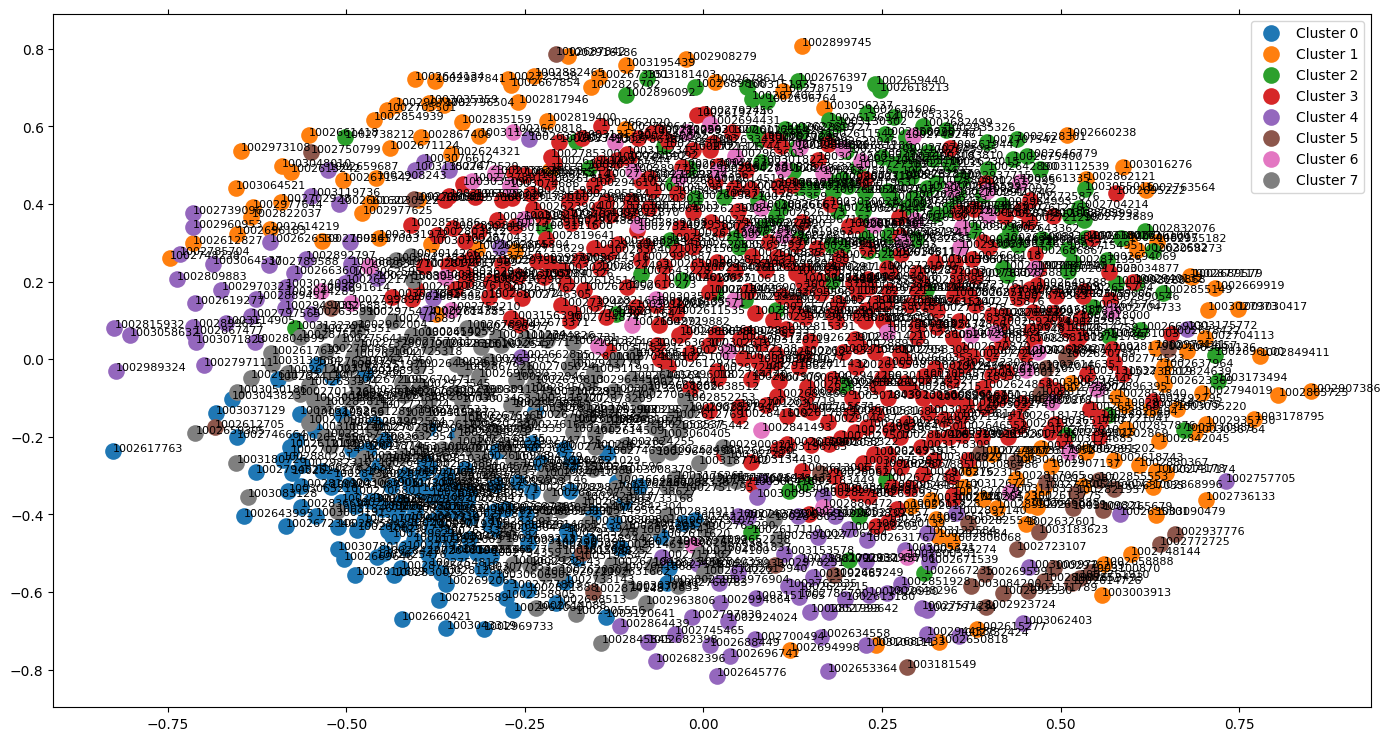

In [23]:
# plot clusters
%matplotlib inline 

titles = data.userid

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1) 
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

plt.show()

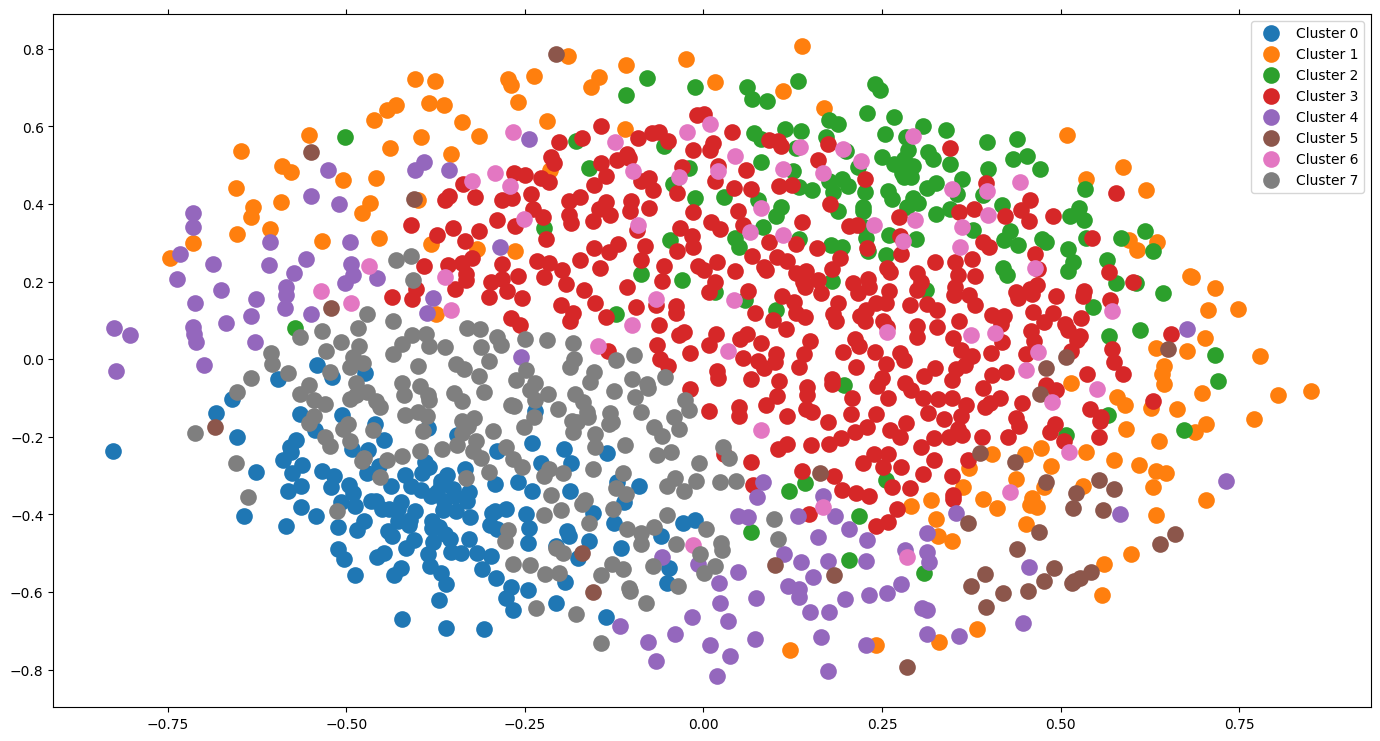

In [24]:
# plot cluster without userid
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)    
plt.show()

In [25]:
#adding cluster labels in the usersData. (add one column into dataframe) 
data['cluster'] = clusters

In [26]:
data.head()

,userid,comments,comments_id,article_id,title,url,pcomment,cluster
0,1002611535,"[Ủa, iOS có tính năng khóa App từ lâu rồi mà. ...","[47968853, 47800135, 47703811, 47645657, 47584...","[4529373, 4527283, 4524455, 4522989, 4521000, ...",[Ý tưởng iOS 17 có khóa ứng dụng - VnExpress S...,[https://vnexpress.net/y-tuong-ios-17-co-khoa-...,ios năng khoá app mục screen time nguyên_nhân ...,3
1,1002611542,[Lâu nay phạt nguội xe máy vẫn là vấn đề nan g...,"[48165879, 48157811, 48157769, 48132386, 48088...","[4537874, 4537422, 4537406, 4535990, 4535329, ...","[Môtô CSGT tông liên hoàn, ba người bị thương ...",[https://vnexpress.net/moto-csgt-tong-lien-hoa...,phạt nguội máy vấn nan_giải phương xác_định ch...,2
2,1002611620,[Messi 0d nhưng lại được định giá gần gấp 3 lầ...,"[48163846, 48163447, 48162509, 48159323, 48156...","[4537829, 4537929, 4537576, 4537847, 4537527, ...",[10 đội tuyển đắt giá nhất tại World Cup 2022 ...,[https://vnexpress.net/10-doi-tuyen-dat-gia-nh...,messi định_giá gấp thiên phản_bội ghi haha lik...,0
3,1002611661,[Hy vọng 30 năm nữa hoàn thành để tôi có thể đ...,"[47983237, 38548809, 37953883, 37023659, 36523...","[4528558, 4226031, 4201350, 4167048, 4144167, ...",[Nghiên cứu đường sắt tốc độ cao 250 km/h - Vn...,[https://vnexpress.net/nghien-cuu-duong-sat-to...,vọng hoàn_thành_thể chuyến chết tội mấy tung t...,3
4,1002611711,[Năm rồi vì 20 giây<br/>Mà cả đội bóng vạ lây ...,"[46444497, 46311714, 43222717, 42102514, 42097...","[4492456, 4488831, 4396253, 4356490, 4356752, ...",[Man Utd có thể nhờ Ferguson thuyết phục Ronal...,[https://vnexpress.net/man-utd-co-the-nho-ferg...,giây đội bóng lây chàng đôn_đáo chạy_làng rải ...,0


# 4. Perform Topic Modelling

In [27]:
# get doc from pcomments
docs = array(data['pcomment'].apply(lambda x: x.split()))

In [28]:
# Built dictionary and corpus from docs
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 6130
Number of documents: 1172
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 4), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 2), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 2), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 3), (44, 2), (45, 1), (46, 2), (47, 3), (48, 1), (49, 4), (50, 1), (51, 3), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 6), (69, 1), (70, 1), (71, 2), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 8), (82, 1), (83, 4), (84, 1), (85, 4), (86, 1), (87, 2), (88, 2), (89, 1), (90, 1), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 8), (99, 1), (100, 2), (101, 1), (102, 2), (103, 4), (104, 1), (1

In [29]:
# add 2 column into dataframe
data['corpus'] = corpus
data['docs'] = docs
# create unique list of names
UniqueNames = data['cluster'].unique()

In [30]:
#create a data frame dictionary to store data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
docscluster={elem : pd.DataFrame for elem in UniqueNames}
corpuscluster={elem : pd.DataFrame for elem in UniqueNames}
dictionarycluster={elem : pd.DataFrame for elem in UniqueNames}

In [31]:
# slip data by cluster
for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data.cluster == key]
    docscluster[key]=data['docs'][data.cluster == key]
    corpuscluster[key]=data['corpus'][data.cluster == key]
    dictionarycluster[key]=Dictionary(docscluster[key])

In [32]:
# create LDA modeling
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [33]:
# save model
lda_model.save("/model_lda_100.model")

# Save model parameters
pickle.dump(lda_model, open("%smodel_lda_100.model"%location, "wb"))

In [34]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.754763656082366

Coherence Score:  0.5571999690515324


## 3.1 Perform topic modelling for each cluster

In [35]:
# Function to loop computing coherence measures for tuning LDAMallet model
#Used c_v parameter as method for computing coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:ocs
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        try:
            model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        except:
            corpus = [dictionary.doc2bow(doc) for doc in docs]
            model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
# topic modeling and calculate coherence_values
model_list={elem : pd.DataFrame for elem in UniqueNames }
coherence_values={ elem : pd.DataFrame for elem in UniqueNames}
for i in np.arange(num_clusters):
    model_list[i], coherence_values[i] = compute_coherence_values(dictionary=dictionarycluster[i]
    , corpus=corpuscluster[i], texts=docscluster[i], start=2, limit=7, step=1)

In [37]:
# Print the coherence scores
# Find number of topic for each cluster

best_value=np.array([])
optimal_model={elem : pd.DataFrame for elem in UniqueNames }
for i in np.arange(num_clusters):
    coherence_values[i]=[value for value in coherence_values[i] if not math.isnan(value)]
    best_value=np.append(best_value, np.amax(coherence_values[i])) 
    t=int(np.argmax(coherence_values[i]))
    optimal_model[i]=model_list[i][t]
    print("Cluster=",i,"has optimal number of topics as", t+2)#######################################################

Cluster= 0 has optimal number of topics as 6
Cluster= 1 has optimal number of topics as 2
Cluster= 2 has optimal number of topics as 4
Cluster= 3 has optimal number of topics as 4
Cluster= 4 has optimal number of topics as 2
Cluster= 5 has optimal number of topics as 6
Cluster= 6 has optimal number of topics as 4
Cluster= 7 has optimal number of topics as 6


In [38]:
coherence_values

{3: [0.5241089449979054,
  0.57818863206588,
  0.6024702500418552,
  0.5950255764112296,
  0.5826902930712777],
 2: [0.6655381705992051,
  0.7020017007724979,
  0.7050445637520089,
  0.6820755847666018,
  0.6922515703532436],
 0: [0.6492599153646348,
  0.6608071662138143,
  0.6634169319795185,
  0.6565067250721963,
  0.6905231560366097],
 7: [0.5544036836552594,
  0.5946879629023005,
  0.5952011032785165,
  0.5720163764280954,
  0.6052530107912472],
 5: [0.7000834636873023,
  0.7118064115949791,
  0.7081441972410495,
  0.6974072684385685,
  0.7170735383620036],
 1: [0.7228497013723834,
  0.7073073464340238,
  0.7228333491722678,
  0.7035137433014833,
  0.704035096689573],
 6: [0.6491565934491295,
  0.6457296389164991,
  0.6537677919739694,
  0.6332223588961179,
  0.6512153907412851],
 4: [0.716659718348055,
  0.680025245309487,
  0.6876464785420547,
  0.6925755713794199,
  0.6740970492388181]}

In [39]:
optimal_model[3].print_topics(num_words=100)

[(0,
  '0.001*"hoàn_toàn" + 0.001*"trace" + 0.001*"giải_trình" + 0.000*"hột" + 0.000*"hét" + 0.000*"next" + 0.000*"vvnbsp" + 0.000*"sài_kinh" + 0.000*"nhông_nhông" + 0.000*"infosys" + 0.000*"semiautomatic" + 0.000*"nheo" + 0.000*"ngôn_ngữ_học" + 0.000*"bàn_lùi" + 0.000*"biên_hoà" + 0.000*"gắt" + 0.000*"ngón" + 0.000*"nghệ_nhân" + 0.000*"ven" + 0.000*"thông_báo_trợ" + 0.000*"chân_giá_trị" + 0.000*"97k" + 0.000*"may_mắn" + 0.000*"bắt_buộc" + 0.000*"gia_cảnh_thể" + 0.000*"cõi" + 0.000*"nhãn_tiền_thiết" + 0.000*"bùng" + 0.000*"thợ" + 0.000*"phô_mai" + 0.000*"diễn_giải" + 0.000*"giác_quan" + 0.000*"đường_hầm" + 0.000*"công_nhân_viên" + 0.000*"rồiblahblah" + 0.000*"khám_chữa" + 0.000*"cảm_động" + 0.000*"kirkland" + 0.000*"then_chốt" + 0.000*"biệt_thự" + 0.000*"thủ_phạm" + 0.000*"vnexpress" + 0.000*"nhung" + 0.000*"hiện_tượng" + 0.000*"mọt_sách" + 0.000*"thừng" + 0.000*"bao_mua" + 0.000*"3tr" + 0.000*"chí" + 0.000*"xác" + 0.000*"trắng" + 0.000*"thi_thể" + 0.000*"40000km" + 0.000*"tàu" + 0.000

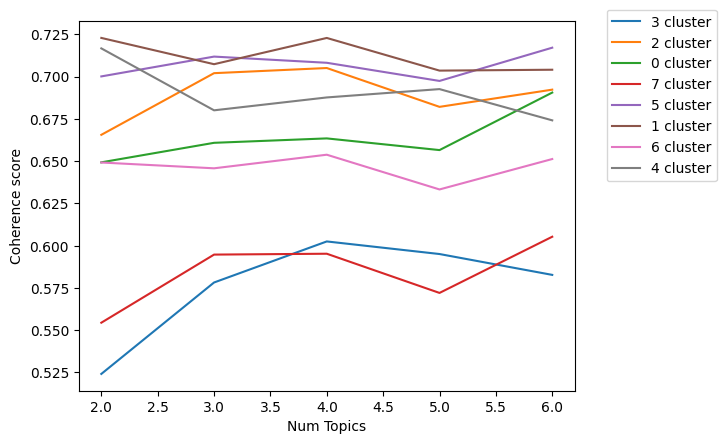

In [40]:
# plot coherence socre of each cluster
limit=7; start=2; step=1;
x={elem:list(range(start, limit, step)) for elem in (UniqueNames)}
for key in x.keys():
    plt.plot(x[key],coherence_values[key], label= str(key)+ ' cluster') 
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    
plt.legend(loc='best',bbox_to_anchor=(1.05, 1.05))
#plt.show()
plt.savefig('Coherence Sscor.png',bbox_inches='tight')

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
lda_model = optimal_model[1]
vis2 = pyLDAvis.gensim.prepare(lda_model, corpuscluster[1], dictionarycluster[1])
vis2

c:\Program Files\Python39\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.092634  0.0       1        1  70.387561
1     -0.092634  0.0       2        1  29.612439, topic_info=           Term       Freq      Total Category  logprob  loglift
758         kia  21.000000  21.000000  Default  30.0000  30.0000
2608  lung_tung  12.000000  12.000000  Default  29.0000  29.0000
2771  xuất_khẩu  10.000000  10.000000  Default  28.0000  28.0000
122         tra  14.000000  14.000000  Default  27.0000  27.0000
3168    phổ_cập   7.000000   7.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
177    lao_động   5.886028  10.210391   Topic2  -6.4936   0.6662
514     lạc_hậu   6.005174  12.489730   Topic2  -6.4736   0.4847
521   nghi_thức   6.117951  15.656734   Topic2  -6.4550   0.2773
65      lợi_hại   6.258747  32.194554   Topic2  -6.4322  -0.4208
2617        rèn   5.629679   9.700358   Topic2  -6.5382   0.6729

[146 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
459       1  0.937810         100
1434      1  0.980000         234
1434      2  0.042609         234
964       2  0.867169         300
1321      1  0.831479   biên_giới
...     ...       ...         ...
205       1  0.989817         đầu
1686      2  0.879666  định_hướng
453       2  0.899458         đời
4198      1  0.961278     đợi_chờ
2155      1  0.973523        đụng

[167 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [42]:
# def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row in enumerate(ldamodel[corpus]):
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)


# 5. Calculate sentiment score for each cluster lean on comments

In [43]:
# read lexicon dictionary
list_word = pd.read_excel(r'D:\ITfiles\PythonFiles\News-Recommendation-System\VnEmoLex.xlsx')
list_word = list_word.drop(['Unnamed: 0'], axis=1)
list_word.Vietnamese = list_word.Vietnamese.str.lower()
list_word.Vietnamese = list_word.Vietnamese.str.strip()
list_word.Vietnamese = list_word.Vietnamese.str.replace(' ', '_')
list_word.columns = ['Vietnamese', 'Positive','Negative',
'Anger', 'Anticipation','Disgust',
'Fear','Joy','Sadness','Surprise',
'Trust','Total']

pos_word = list_word.loc[(list_word.Positive == 1) | (list_word.Anticipation == 1) 
| (list_word.Joy == 1) | (list_word.Surprise == 1) | (list_word.Trust == 1),'Vietnamese'].to_list()
neg_word = list_word.loc[(list_word.Negative == 1) | (list_word.Anger == 1) |
(list_word.Disgust == 1) | (list_word.Fear == 1) | (list_word.Sadness == 1) ,'Vietnamese'].to_list()

# build function to calculate_sentiment_score
def calculate_sentiment_score(i):
    num_pos = DataFrameDict[i].docs.map(lambda x: len([i for i in x if i in pos_word]))
    num_neg = DataFrameDict[i].docs.map(lambda x: len([i for i in x if i in neg_word]))
    total_len = DataFrameDict[i].docs.map(lambda x: len(x))

    return round((num_pos.sum() - num_neg.sum())/ total_len.sum(),6)
    

In [44]:
sentimentscorecluster = {elem : pd.DataFrame for elem in UniqueNames}

for i in DataFrameDict.keys():
    sentimentscorecluster[i] = calculate_sentiment_score (i)
    print('{}, score: {}'.format(i,sentimentscorecluster[i]))

3, score: 0.055732
2, score: 0.038813
0, score: 0.042261
7, score: 0.042942
5, score: 0.018445
1, score: 0.067522
6, score: 0.043491
4, score: 0.055464


# 6. Analyze News articles

In [45]:
# Load dataset
df_articles = pd.read_csv(r'D:\ITfiles\PythonFiles\News-Recommendation-System\Datatest\TongHop.csv')

In [46]:
df_articles.head(10)

,URL,article,news_content
0,https://vnexpress.net/co-gai-met-moi-vi-qua-xi...,Cô gái mệt mỏi vì quá xinh đẹp,"MỹMái tóc bồng bềnh, khuôn mặt xinh đẹp cùng v..."
1,https://vnexpress.net/dau-bep-doi-tuyen-nhat-t...,Đầu bếp đội tuyển Nhật tiếp tục nấu món may mắ...,Hy vọng món lươn nướng sẽ mang lại chiến thắng...
2,https://vnexpress.net/bao-nhieu-lau-nen-goi-da...,Bao nhiêu lâu nên gội đầu một lần?,Tần suất gội đầu của mỗi người tùy thuộc vào n...
3,https://vnexpress.net/lam-the-nao-giup-cha-me-...,Làm thế nào giúp cha mẹ già dùng smartphone?,Hầu hết người già đều hiểu biết hạn chế về côn...
4,https://vnexpress.net/tai-sao-khong-nen-ham-no...,Tại sao không nên ham nổi tiếng?,Nổi tiếng là thứ rất nhiều người khao khát như...
5,https://vnexpress.net/biet-thu-pho-theo-kien-t...,Biệt thự phố theo kiến trúc Á Đông,Q Villa được xây dựng trên mảnh đất diện tích ...
6,https://vnexpress.net/nhung-gian-qua-cua-ba-me...,Những giàn quả của bà mẹ Hải Dương,"Khác với các loại bầu bí, trồng các loại dưa y..."
7,https://vnexpress.net/th-ra-mat-sua-trai-cay-b...,TH ra mắt sữa trái cây bổ sung vi chất cho bé,"TH ra mắt TH true Juice milk Topkid, nước uống..."
8,https://vnexpress.net/cach-chon-bon-tam-trong-...,Cách chọn bồn tắm trong không gian nội thất nh...,Phòng tắm nhà tôi có diện tích nhỏ nhưng lại m...
9,https://vnexpress.net/dau-hieu-ban-la-ung-vien...,Dấu hiệu bạn là ứng viên trúng tuyển,Những dấu hiệu nhà tuyển dụng xem bạn là ứng v...


In [47]:
# function to preprocess articles
def processArticles(contents):
    #cleaning of contents
    cleanedcontents = []
    for content in contents:
        clean = re.compile('<.*?>')
        content = re.sub(clean, ' ', content) # remove html tags

        cm = re.sub('http\S+', '', content) #remove links
        
        cm = "".join([char for char in cm if char not in string.punctuation]) #remove punctuations
        
        cm = cm.lower() #converting to lowercase letters
        
        cm = ' '.join([word for word in cm.split() if word not in (stop)]) #removing stop words (có vấn đề)
        
        cm = ' '.join([word for word in cm.split() if len(word)>2])
        
        cm = segmenter.word_segment(cm)[0] #tokenize

        cleanedcontents.append(cm)
        
    return cleanedcontents


df_articles['news_content'] = processArticles(df_articles['news_content'])

<>:9: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \S
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\3127147785.py:9: DeprecationWarning: invalid escape sequence \S
  cm = re.sub('http\S+', '', content) #remove links


## 5.1 Topic modeling

In [48]:
# tạo docs, dictionary
from numpy import array

docs = array(df_articles['news_content'].apply(lambda x : x.split()))
df_articles['docs'] = df_articles['news_content'].apply(lambda x : x.split())

In [49]:
# Remove rare and common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1423
Number of documents: 548


In [50]:
# Function to analyze the developed topic models on unseen corpus of texts (in our case News articles)
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [52]:
# The percent contribution of each topic model considered as metric to assign topic score
df_topic_sents_keywords={elem : pd.DataFrame for elem in UniqueNames}
topicss=pd.DataFrame()
for i in range(len(UniqueNames)):
    mod=optimal_model[i]
    temp={'cluster':i,
         'model':mod}
    topicss=topicss.append(temp, ignore_index=True)
    df_topic_sents_keywords[i] = format_topics_sentences(ldamodel=mod, corpus=corpus, texts=docs)
    # Centre the percent contribution by subtracting the mean. This standardises topic score (chuẩn hóa)
    df_topic_sents_keywords[i]['Diff']= df_topic_sents_keywords[i]['Perc_Contribution']-np.mean(df_topic_sents_keywords[i]['Perc_Contribution'])

C:\Users\marti\AppData\Local\Temp\ipykernel_15228\3113384864.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topicss=topicss.append(temp, ignore_index=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\1391231544.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\3113384864.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topicss=topicss.append(temp, ignore_index=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\1391231544.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

In [53]:
df_topic_sents_keywords[0]

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0,Diff
0,2,0.9297,"tôn, mắt, lấp_lánh, khung_thành, nhựa, tra, kh...","[mỹmái, tóc, bồng_bềnh, khuôn_mặt, xinh_đẹp, v...",0.035501
1,2,0.9400,"tôn, mắt, lấp_lánh, khung_thành, nhựa, tra, kh...","[vọng, món, lươn, nướng, chiến_thắng, croatia,...",0.045801
2,2,0.9392,"tôn, mắt, lấp_lánh, khung_thành, nhựa, tra, kh...","[tần_suất, gội, đầu, tuỳ, yếu, bao, kiểu, tóc,...",0.045001
3,2,0.9084,"tôn, mắt, lấp_lánh, khung_thành, nhựa, tra, kh...","[hầu, già, hạn_chế, công_nghệ, khăn, dụng, thi...",0.014201
4,2,0.8596,"tôn, mắt, lấp_lánh, khung_thành, nhựa, tra, kh...","[nổi_tiếng, khao_khát, đồng_thời, huỷ_hoại, hạ...",-0.034599
...,...,...,...,...,...
543,2,0.9695,"tôn, mắt, lấp_lánh, khung_thành, nhựa, tra, kh...","[huyện, ngoại_thành, nghị, chủ_trương, thành_p...",0.075301
544,2,0.9980,"tôn, mắt, lấp_lánh, khung_thành, nhựa, tra, kh...","[địa_phương, chậm, giải_phóng, mặt, tốc, bắc_n...",0.103801
545,2,0.9982,"tôn, mắt, lấp_lánh, khung_thành, nhựa, tra, kh...","[quyền, thành_phố, sung, hai, địa_danh_son, th...",0.104001
546,2,0.9845,"tôn, mắt, lấp_lánh, khung_thành, nhựa, tra, kh...","[lịch, nghỉ, tết, 2023, 2023, công_chức, lao_đ...",0.090301


## 5.2 Calculate sentiment scores for each article

In [54]:
list_word = pd.read_excel(r'D:\ITfiles\PythonFiles\News-Recommendation-System\VnEmoLex.xlsx')
list_word = list_word.drop(['Unnamed: 0'], axis=1)
list_word.Vietnamese = list_word.Vietnamese.str.lower()
list_word.Vietnamese = list_word.Vietnamese.str.strip()
list_word.Vietnamese = list_word.Vietnamese.str.replace(' ', '_')
list_word.columns = ['Vietnamese', 'Positive','Negative',
'Anger', 'Anticipation','Disgust',
'Fear','Joy','Sadness','Surprise',
'Trust','Total']

pos_word = list_word.loc[(list_word.Positive == 1) | (list_word.Anticipation == 1) 
| (list_word.Joy == 1) | (list_word.Surprise == 1) | (list_word.Trust == 1),'Vietnamese'].to_list()
neg_word = list_word.loc[(list_word.Negative == 1) | (list_word.Anger == 1) |
(list_word.Disgust == 1) | (list_word.Fear == 1) | (list_word.Sadness == 1) ,'Vietnamese'].to_list()

num_pos = df_articles.docs.map(lambda x: len([i for i in x if i in pos_word]))
num_neg = df_articles.docs.map(lambda x: len([i for i in x if i in neg_word]))
total_len = df_articles.docs.map(lambda x: len(x))

df_articles['sentiment_score'] = round((num_pos- num_neg)/ total_len,6)

## 5.3 Calculate metric score recommendation

In [55]:
sentiment={elem: pd.DataFrame for elem in UniqueNames}
#subjectivit={elem: pd.DataFrame for elem in UniqueNames}
w1=0.8 # Topic modelling weight
w2=0.2 # Sentiment score weight
for i in range(len(UniqueNames)):
    sentiment[i]=cosine_similarity(np.array(df_articles.iloc[:, -1]).reshape(-1, 1),np.array([sentimentscorecluster[i]]).reshape(-1, 1))
    #subjectivit[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([subjectivitycluster[i]]).reshape(-1, 1))
    df_topic_sents_keywords[i]['Sentiment']=sentiment[i]
    #df_topic_sents_keywords[i]['Subjectivity']=subjectivit[i]
    df_topic_sents_keywords[i]['Metric']=w1*df_topic_sents_keywords[i]['Diff'] + w2*df_topic_sents_keywords[i]['Sentiment']

In [56]:
recommend=pd.DataFrame()
metric_value=pd.DataFrame()
rec=np.array([])
for i in range(len(docs)):
    for j in range(len(UniqueNames)):
        rec=np.append(rec, df_topic_sents_keywords[j].iloc[i,-1])

    recommend=recommend.append(pd.Series(np.argmax(rec)),ignore_index=True)
    metric_value=metric_value.append(pd.Series(np.amax(rec)),ignore_index=True)
    rec=np.array([])


C:\Users\marti\AppData\Local\Temp\ipykernel_15228\1334659417.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommend=recommend.append(pd.Series(np.argmax(rec)),ignore_index=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\1334659417.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_value=metric_value.append(pd.Series(np.amax(rec)),ignore_index=True)


In [57]:
recommend['metric']=metric_value
recommend['url']=df_articles['URL']
recommend['article_text']=df_articles['news_content']
recommend.rename(columns={0:'cluster'},inplace=True)

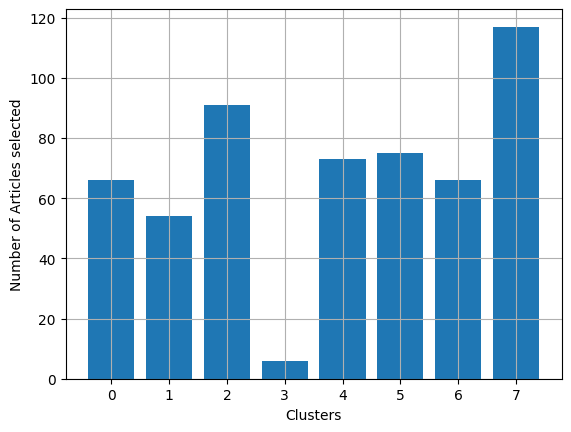

In [94]:
plt.bar(recommend['cluster'].value_counts().index,recommend['cluster'].value_counts())
plt.grid()
plt.xlabel('Clusters')
plt.ylabel('Number of Articles selected')
plt.savefig('Percentage Recommend.png',bbox_inches='tight')

In [58]:
recommend.to_csv('%srecommend.csv'%location,index=None)

# 7. Recommendation system

In [59]:
# read data 
test_data = pd.read_csv(r'D:\ITfiles\PythonFiles\News-Recommendation-System\Use-vnexpress-data\data.csv')

test_data =  test_data.iloc[20000:25000,:]

In [60]:
# get user data to recommend
userid_list = list(test_data['userid'].unique())
data_rec = pd.DataFrame(columns = ["userid","comments","comments_id","article_id","title",'url'])

for i in userid_list:
    try:
        temp = int(i)
        data_rec = combineComments(i,data_rec)
    except:
        print('x')
        continue

x


C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\2350712596.

In [61]:
# tiền xử lý
data_rec["pcomment"] = data_rec['comments'].apply(lambda x : processComments(x))

## 6.1 Function to calculate final score for recommendations

In [62]:
def get_jaccard_sim(str1, str2):
    a = set(str1)
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [88]:
def GetUserRec(recommend, pcomments,cluster):

    articles=recommend[recommend['cluster']==cluster]
    articles.dropna(inplace=True)
    articles['corp']= processArticles(articles['article_text'])

    articles['jaccard']=articles['article_text'].apply(lambda x:get_jaccard_sim(pcomments,x))
    articles['final_score']=0.5*articles['jaccard']+0.5*articles['metric']
    ranked=articles.sort_values(by=['final_score'], ascending=False)
    
    #print('comments list: ',pcomments)
    #print('cluster: ', cluster)
    #print('articles: ', articles)

    return ranked

## 6.2 Pipeline to recommend

In [70]:
# 6.2.1 read model
tfidf_vectorizer = pickle.load(open('model/model_tfidf.pickle.dat','rb'))
km = pickle.load(open('model/model_kmeans.pickle.dat','rb'))


In [78]:
# 6.2.1 cluster 
tfidf_matrix = tfidf_vectorizer.transform(data_rec.pcomment)
cluster = km.predict(tfidf_matrix)
cluster

array([4, 3, 5, 6, 7, 1, 4, 3, 3, 3, 2, 3, 5, 3, 3, 7, 0, 4, 3, 2, 2, 2,
       7, 0, 3, 0, 1, 3, 3, 2, 4, 7, 3, 2, 0, 3, 7, 2, 6, 1, 3, 3, 7, 4,
       3, 7, 2, 7, 3, 0, 1, 3, 6, 1, 3, 3])

In [72]:
# 6.2.3 read articles recommend dataframe
recommend = pd.read_csv('model/recommend.csv')
recommend.sort_values(by='metric',ascending=False,inplace=True)

In [90]:
# 6.2.4 recommend
print(GetUserRec(recommend,data_rec["pcomment"].values[6],cluster[6])['url'].head(10).values)

['https://vnexpress.net/salon-toc-di-dong-danh-cho-nguoi-ngheo-4543536.html'
 'https://vnexpress.net/kinh-james-webb-chup-anh-thien-ha-va-cham-du-doi-4543139.html'
 'https://vnexpress.net/tran-gia-kho-anh-huong-den-dong-chay-dau-nga-4543641.html'
 'https://vnexpress.net/ba-dac-diem-de-thay-o-nguoi-co-diem-tin-dung-cao-4544031.html'
 'https://vnexpress.net/giai-tri/phim/thu-vien-phim/tro-tan-ruc-ro-522'
 'https://vnexpress.net/23-ngay-o-nam-cuc-cua-du-khach-viet-4543792.html'
 'https://vnexpress.net/du-mon-ngon-tu-sam-bien-o-quang-ninh-4541337.html'
 'https://vnexpress.net/cach-de-hap-dan-hon-trong-mat-nguoi-khac-4538764.html'
 'https://vnexpress.net/bep-cao-bao-nhieu-la-hop-ly-4543070.html'
 'https://vnexpress.net/van-gaal-nguoi-tho-han-vi-dai-cua-bong-da-ha-lan-4544285.html']


C:\Users\marti\AppData\Local\Temp\ipykernel_15228\359999556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles.dropna(inplace=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\359999556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles['corp']= processArticles(articles['article_text'])
C:\Users\marti\AppData\Local\Temp\ipykernel_15228\359999556.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht